In [1]:
# Cell 1: Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization, LayerNormalization, Reshape, Permute, Bidirectional, Add, Attention, Flatten, TimeDistributed, Conv2DTranspose, Conv2D, Layer, Concatenate, Multiply, AdditiveAttention # Added Multiply, AdditiveAttention for potential SelfAttention implementation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop # Added RMSprop as an option for WGAN
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, f1_score, roc_curve # Moved confusion_matrix here
import librosa
import soundfile as sf
# import noisereduce as nr # Consider if still needed/effective
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
import logging
from tqdm.notebook import tqdm # Use tqdm.notebook for better Jupyter integration
import random
import seaborn as sns # Added for confusion matrix plotting
tf.config.optimizer.set_jit(False)
print("XLA JIT compilation disabled.")

# WGAN-GP specific
from tensorflow import GradientTape

# Create directory for saving figures
FIGURES_DIR = 'training_figures_wgan_sa' # Changed dir name
os.makedirs(FIGURES_DIR, exist_ok=True)

# Configure logging
logging.basicConfig(filename='audio_errors_wgan_sa.log', level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')

print(f"TensorFlow version: {tf.__version__}")

2025-04-08 00:13:20.627452: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 00:13:20.638948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744051400.652243  304437 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744051400.656119  304437 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744051400.666675  304437 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

XLA JIT compilation disabled.
TensorFlow version: 2.19.0


In [2]:
# Cell 2: Force GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error configuring GPU: {e}")
else:
    print("No GPU devices found. Falling back to CPU.")

# Set mixed precision policy if desired (can speed up training on compatible GPUs)
#from tensorflow.keras import mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)
#print('Mixed precision enabled')

GPU is available and configured.


In [3]:
# Cell 3: Audio Loading and Preprocessing Function
def load_and_preprocess_audio(file_path, sr=16000, duration=4):
    try:
        # Load audio, potentially reducing noise first if beneficial
        audio, current_sr = librosa.load(file_path, sr=None, duration=duration) # Load native SR first

        # Optional: Noise Reduction (experiment if needed)
        # audio = nr.reduce_noise(y=audio, sr=current_sr)

        # Resample if necessary
        if current_sr != sr:
            audio = librosa.resample(audio, orig_sr=current_sr, target_sr=sr)

        # Pad or truncate to fixed duration *before* augmentation/normalization
        target_len = sr * duration
        if len(audio) < target_len:
            audio = np.pad(audio, (0, target_len - len(audio)), mode='constant')
        else:
            audio = audio[:target_len]

        # Data Augmentation (applied *before* normalization)
        if np.random.random() < 0.5: # 50% chance
            augmentation_type = np.random.choice(['noise', 'pitch', 'speed'])
            if augmentation_type == 'noise':
                noise_amp = 0.005 * np.random.uniform(0.1, 1.0) * np.max(np.abs(audio)) # Scale noise relative to audio
                noise = np.random.randn(len(audio)) * noise_amp
                audio = audio + noise
            elif augmentation_type == 'pitch':
                pitch_shift_steps = np.random.uniform(-2.5, 2.5)
                audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=pitch_shift_steps)
            else: # speed (time stretch)
                speed_rate = np.random.uniform(0.85, 1.15)
                audio = librosa.effects.time_stretch(audio, rate=speed_rate)
                 # Time stretching changes length, re-pad/truncate
                if len(audio) < target_len:
                    audio = np.pad(audio, (0, target_len - len(audio)), mode='constant')
                else:
                    audio = audio[:target_len]

        # Normalize audio (peak normalization) - crucial for consistency
        max_amp = np.max(np.abs(audio))
        if max_amp > 1e-6: # Avoid division by zero
             audio = audio / max_amp
        # Optional: RMS normalization instead
        # rms = np.sqrt(np.mean(audio**2))
        # if rms > 1e-6:
        #    audio = audio / rms * 0.5 # Scale to a target RMS

        return audio
    except Exception as e:
        logging.error(f"Error loading/preprocessing {file_path}: {e}")
        print(f"Error loading/preprocessing {file_path}: {e}")
        return None

In [4]:
# Cell 4: Feature Extraction Function
def extract_features(audio, sr=16000, n_mels=80, n_fft=2048, hop_length=512):
    if audio is None:
        return None
    try:
        # Extract mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=sr,
            n_mels=n_mels,
            n_fft=n_fft,
            hop_length=hop_length
        )
        # Convert to log scale (dB)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize features (per spectrogram) - Standard Scaling
        mean = np.mean(log_mel_spec)
        std = np.std(log_mel_spec)
        if std > 1e-6: # Avoid division by zero
            log_mel_spec = (log_mel_spec - mean) / std
        else:
            log_mel_spec = log_mel_spec - mean # Just center if std is near zero

        # Ensure the shape is consistent (should be handled by fixed duration loading)
        # Expected frames: int(np.ceil(target_len / hop_length)) -> int(ceil(16000*4/512)) = 125? Check calculation
        # target_len = 16000 * 4 = 64000
        # expected_frames = 64000 // hop_length + 1 if 64000 % hop_length != 0 else 64000 // hop_length
        # expected_frames = 64000 / 512 = 125. Check librosa padding. It often adds a frame. Let's stick to TARGET_FRAMES=126 based on previous findings.

        return log_mel_spec # Shape (n_mels, n_frames) e.g. (80, 126)

    except Exception as e:
        logging.error(f"Error extracting features: {e}")
        print(f"Error extracting features: {e}")
        return None

In [5]:
# Cell 5: Class Distribution Analysis Function
def analyze_class_distribution(data_path):
    try:
        real_dir = os.path.join(data_path, 'real')
        fake_dir = os.path.join(data_path, 'fake')
        real_count = len([f for f in os.listdir(real_dir) if f.endswith('.wav')]) if os.path.exists(real_dir) else 0
        fake_count = len([f for f in os.listdir(fake_dir) if f.endswith('.wav')]) if os.path.exists(fake_dir) else 0
        total = real_count + fake_count
        if total == 0:
            print(f"\nNo .wav files found in {data_path}")
            return {'real': 0, 'fake': 0}
        print(f"\nClass Distribution for {data_path}:")
        print(f"Real: {real_count} ({real_count/total*100:.2f}%)")
        print(f"Fake: {fake_count} ({fake_count/total*100:.2f}%)")
        return {'real': real_count, 'fake': fake_count}
    except FileNotFoundError:
        print(f"\nError: Data path not found - {data_path}")
        return {'real': 0, 'fake': 0}
    except Exception as e:
        logging.error(f"Error analyzing distribution for {data_path}: {e}")
        print(f"Error analyzing distribution for {data_path}: {e}")
        return {'real': 0, 'fake': 0}

In [6]:
# Cell 6: Data Generators

# Define the fixed number of frames for GAN/Classifier consistency
TARGET_FRAMES = 126 # Recalculate based on sr=16000, duration=4, hop_length=512 if needed

# Data generator for STANDALONE CLASSIFIER training (Yields X, y, sample_weights)
# --- (data_generator_classifier function remains the same as corrected before) ---
def data_generator_classifier(data_path, batch_size=32, shuffle=True, target_frames=TARGET_FRAMES, sr=16000, duration=4, n_mels=80, n_fft=2048, hop_length=512):
    real_files = []
    fake_files = []
    try:
        real_dir = os.path.join(data_path, 'real')
        fake_dir = os.path.join(data_path, 'fake')
        if os.path.exists(real_dir):
             real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.wav')]
        if os.path.exists(fake_dir):
             fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.wav')]
    except FileNotFoundError as e:
        print(f"Error finding directories in {data_path}: {e}")
        return

    all_files = real_files + fake_files
    labels = [1] * len(real_files) + [0] * len(fake_files) # Real=1, Fake=0

    if not all_files:
        print(f"No WAV files found in {data_path}. Classifier generator stopping.")
        return

    total_samples = len(all_files)
    class_weights = {
        1: total_samples / (2 * len(real_files)) if len(real_files) > 0 else 1.0,
        0: total_samples / (2 * len(fake_files)) if len(fake_files) > 0 else 1.0,
    }
    print(f"Using class weights: {class_weights} for path {data_path}")


    indices = np.arange(total_samples)
    while True:
        if shuffle:
            np.random.shuffle(indices)

        for i in range(0, total_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_files = [all_files[k] for k in batch_indices]
            batch_labels = [labels[k] for k in batch_indices]

            batch_x = []
            batch_y = []
            batch_sample_weights = []

            for file_path, label in zip(batch_files, batch_labels):
                audio = load_and_preprocess_audio(file_path, sr=sr, duration=duration)
                if audio is None: continue

                features = extract_features(audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
                if features is None: continue

                current_frames = features.shape[1]
                if current_frames != target_frames:
                     if current_frames < target_frames:
                        pad_width = target_frames - current_frames
                        padded_features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
                     else:
                        padded_features = features[:, :target_frames]
                else:
                    padded_features = features

                batch_x.append(padded_features)
                batch_y.append(label)
                batch_sample_weights.append(class_weights[label])

            # --- Check for classifier generator ---
            if not batch_x:
                print(f"Warning: Skipping empty batch yield in data_generator_classifier for path {data_path}")
                continue

            batch_x_4d = np.expand_dims(np.array(batch_x), axis=-1).astype(np.float32)
            batch_y_arr = np.array(batch_y).astype(np.float32)
            batch_weights_arr = np.array(batch_sample_weights).astype(np.float32)
            yield batch_x_4d, batch_y_arr, batch_weights_arr


# Data generator for WGAN training (Yields real fake samples X only)
# --- (MODIFIED data_generator_gan function) ---
def data_generator_gan(data_path, batch_size=32, shuffle=True, target_frames=TARGET_FRAMES, sr=16000, duration=4, n_mels=80, n_fft=2048, hop_length=512):
    fake_files = []
    try:
        fake_dir = os.path.join(data_path, 'fake')
        if os.path.exists(fake_dir):
             fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.wav')]
    except FileNotFoundError as e:
        print(f"Error finding fake directory in {data_path}: {e}")
        return

    if not fake_files:
        print(f"No fake WAV files found in {data_path}. GAN generator stopping.")
        return

    total_samples = len(fake_files)
    indices = np.arange(total_samples)

    while True:
        if shuffle:
            np.random.shuffle(indices)

        for i in range(0, total_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_files = [fake_files[k] for k in batch_indices]

            batch_x = []

            for file_path in batch_files:
                audio = load_and_preprocess_audio(file_path, sr=sr, duration=duration)
                if audio is None: continue

                features = extract_features(audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
                if features is None: continue

                current_frames = features.shape[1]
                if current_frames != target_frames:
                    if current_frames < target_frames:
                        pad_width = target_frames - current_frames
                        padded_features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
                    else:
                        padded_features = features[:, :target_frames]
                else:
                     padded_features = features

                batch_x.append(padded_features)

            # ---> ADD THIS CHECK for GAN generator <---
            if not batch_x:
                print(f"Warning: Skipping empty batch yield in data_generator_gan for path {data_path}")
                continue # Skip yield if batch ended up empty

            # If batch is not empty, yield the data
            batch_x_4d = np.expand_dims(np.array(batch_x), axis=-1).astype(np.float32)
            yield batch_x_4d # Yield only the features (4D array)

In [7]:
# Cell 7: Self-Attention Layer (SAGAN style)

class SelfAttention(Layer):
    """
    Self-attention layer based on SAGAN.
    Input shape: (batch, height, width, channels)
    Output shape: (batch, height, width, channels_out) where channels_out is typically channels
    """
    def __init__(self, channels_out=None, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels_out = channels_out

    def build(self, input_shape):
        self.input_channels = input_shape[-1]
        if self.channels_out is None:
            self.channels_out = self.input_channels

        # Convolution layers for query, key, value
        # Use 1x1 convolutions to reduce/transform channels
        self.f = Conv2D(self.input_channels // 8, kernel_size=1, strides=1, padding='same', name='conv_f') # Query
        self.g = Conv2D(self.input_channels // 8, kernel_size=1, strides=1, padding='same', name='conv_g') # Key
        self.h = Conv2D(self.channels_out, kernel_size=1, strides=1, padding='same', name='conv_h')        # Value

        # Final 1x1 convolution
        self.out_conv = Conv2D(self.channels_out, kernel_size=1, strides=1, padding='same', name='conv_out')

        # Learnable scale parameter
        self.gamma = self.add_weight(name='gamma', shape=(1,), initializer='zeros', trainable=True)

        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        batch_size, height, width, num_channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        location_num = height * width
        downsampled_num = location_num

        # Query (f), Key (g), Value (h) projections
        f_proj = self.f(x) # Shape: (batch, h, w, c/8)
        g_proj = self.g(x) # Shape: (batch, h, w, c/8)
        h_proj = self.h(x) # Shape: (batch, h, w, c_out)

        # Reshape for matrix multiplication
        f_flat = tf.reshape(f_proj, shape=(batch_size, location_num, self.input_channels // 8)) # (batch, h*w, c/8)
        g_flat = tf.reshape(g_proj, shape=(batch_size, location_num, self.input_channels // 8)) # (batch, h*w, c/8)
        h_flat = tf.reshape(h_proj, shape=(batch_size, location_num, self.channels_out))       # (batch, h*w, c_out)

        # Attention map calculation
        # Transpose g for matmul: (batch, c/8, h*w)
        g_flat_t = tf.transpose(g_flat, perm=[0, 2, 1])
        # Attention score: (batch, h*w, c/8) x (batch, c/8, h*w) -> (batch, h*w, h*w)
        attention_score = tf.matmul(f_flat, g_flat_t)
        attention_prob = tf.nn.softmax(attention_score, axis=-1) # Apply softmax across locations

        # Apply attention map to value projection
        # (batch, h*w, h*w) x (batch, h*w, c_out) -> (batch, h*w, c_out)
        attention_output = tf.matmul(attention_prob, h_flat)

        # Reshape back to image format
        attention_output_reshaped = tf.reshape(attention_output, shape=(batch_size, height, width, self.channels_out))

        # Apply final 1x1 convolution and scale by gamma
        o = self.out_conv(attention_output_reshaped)
        y = self.gamma * o + x # Additive skip connection

        return y

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.channels_out,)

In [8]:
# Cell 8: Generator Model (with Self-Attention)

def create_generator(latent_dim, output_shape): # output_shape (n_mels, n_frames) e.g., (80, 126)
    """Creates the generator model with Self-Attention."""
    n_mels, n_frames = output_shape
    init_h, init_w = n_mels // 8, n_frames // 8 # Calculate initial dimensions based on 3 upsamples (2*2*2=8)
    init_c = 128 # Initial channels

    if init_h * 8 != n_mels or init_w * 8 != n_frames:
         print(f"Warning: Output shape {output_shape} might not be perfectly reached with 3 strides of 2. Adjusting initial size or layers.")
         # Adjust init_w slightly if needed, e.g. target 128 -> 16, target 126 -> 16 (trim later)
         init_w = (n_frames + 7) // 8 # Ceiling division equivalent for width

    nodes = init_h * init_w * init_c

    model = Sequential(name='generator')
    model.add(Input(shape=(latent_dim,)))

    # Dense layer and reshape
    model.add(Dense(nodes))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2)) # Use negative_slope
    model.add(Reshape((init_h, init_w, init_c))) # e.g., (10, 16, 128)

    # Upsample 1: (10, 16, 128) -> (20, 32, 64)
    model.add(Conv2DTranspose(init_c // 2, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)) # Typically use_bias=False with Norm
    model.add(LayerNormalization()) # Using LayerNorm instead of BatchNorm
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))

    # Upsample 2: (20, 32, 64) -> (40, 64, 32)
    model.add(Conv2DTranspose(init_c // 4, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(LayerNormalization())
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))

    # Add Self-Attention Layer Here (applied to 40x64 feature map)
    # Note: Attention can be computationally expensive. Apply strategically.
    model.add(SelfAttention(channels_out=init_c // 4)) # Keep channels the same
    # model.add(LayerNormalization()) # Optional normalization after attention
    # model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2)) # Optional activation after attention

    # Upsample 3: (40, 64, 32) -> (80, 128, 1)
    model.add(Conv2DTranspose(1, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='tanh'))

    # Final adjustment layer if needed (e.g., width 128 -> 126)
    current_width = init_w * 8
    if current_width != n_frames:
        print(f"Generator adding final Conv2D to adjust width from {current_width} to {n_frames}")
        # Calculate kernel size needed for 'valid' padding: K = W_in - W_out + 1
        kernel_w = current_width - n_frames + 1
        if kernel_w > 0:
             model.add(Conv2D(1, kernel_size=(1, kernel_w), padding='valid', activation='tanh'))
        else:
            # This case shouldn't happen with the init_w calculation but handle just in case
             print(f"Warning: Could not adjust width with Conv2D. Current {current_width}, Target {n_frames}")
             # May need padding='same' and cropping layer if kernel_w is not positive

    # Ensure final output shape is correct
    # model.add(Reshape((n_mels, n_frames, 1))) # Add reshape just to be certain, though last Conv should handle it

    return model

In [9]:
# Cell 9: Critic (Discriminator) Model (with Self-Attention) - NO DROPOUT

def create_critic(input_shape): # input_shape (n_mels, n_frames) e.g., (80, 126)
    """Creates the Critic model for WGAN-GP with Self-Attention. NO DROPOUT."""
    n_mels, n_frames = input_shape
    model_input_shape = (n_mels, n_frames, 1) # Expects (80, 126, 1)

    model = Sequential(name='critic')
    model.add(Input(shape=model_input_shape))

    # Layer 1
    model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    # model.add(Dropout(0.25)) # REMOVED

    # Layer 2
    model.add(Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(LayerNormalization())
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    # model.add(Dropout(0.25)) # REMOVED

    # Add Self-Attention Layer Here
    model.add(SelfAttention(channels_out=128))

    # Layer 3
    model.add(Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(LayerNormalization())
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    # model.add(Dropout(0.25)) # REMOVED (If you had one here)

    # Flatten and Output Score
    model.add(Flatten())
    model.add(Dense(1))

    return model

In [10]:
# Cell 10: Define the GAN Model (Not used for WGAN-GP training loop)
# def create_gan(generator, discriminator, latent_dim):
#     """Creates the combined GAN model."""
#     # Make discriminator non-trainable
#     discriminator.trainable = False
#
#     # Stack generator and discriminator
#     gan_input = Input(shape=(latent_dim,))
#     gan_output = discriminator(generator(gan_input))
#     gan = Model(gan_input, gan_output)
#
#     return gan

In [11]:
# Cell 11: Data Path and Parameters

# Data Paths
train_data_path = 'datasetNEW/train'
dev_data_path = 'datasetNEW/dev'
eval_data_path = 'datasetNEW/eval'

# Define the fixed number of frames
TARGET_FRAMES = 126
N_MELS = 80
mel_spectrogram_shape = (N_MELS, TARGET_FRAMES)

# WGAN-GP specific parameters
latent_dim = 100
n_critic = 5         # Train critic 5 times per generator update
gp_weight = 1.0     # Gradient penalty weight
gan_epochs = 75      # WGAN often needs more epochs, adjust as needed
gan_batch_size = 8  # Adjust based on GPU memory (WGAN-GP can be memory intensive)

# Optimizers (Typical WGAN settings: lower LR, betas=(0.5, 0.9))
critic_optimizer = Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9) # TRY LOWER LR
generator_optimizer = Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9)
# critic_optimizer = RMSprop(learning_rate=0.00005) # Alternative optimizer
# generator_optimizer = RMSprop(learning_rate=0.00005)

# Create instances
generator = create_generator(latent_dim, mel_spectrogram_shape)
critic = create_critic(mel_spectrogram_shape)

# Diagnostic Code: Verify Output Shape
test_noise = tf.random.normal((1, latent_dim))
generated_image = generator(test_noise, training=False) # Use tf.random and call model directly
critic_output = critic(generated_image, training=False)
print("Shape of generated image (Generator Output):", generated_image.shape)
print("Shape of critic output:", critic_output.shape)

critic_input_shape_expected = (mel_spectrogram_shape[0], mel_spectrogram_shape[1], 1)
print("Expected shape for Critic Input:", critic_input_shape_expected)
assert generated_image.shape[1:] == critic_input_shape_expected, "Generator output shape mismatch!"
assert len(critic_output.shape) == 2 and critic_output.shape[1] == 1, "Critic output shape mismatch!"


# Report the models
print("\n--- Generator Summary ---")
generator.summary()
print("\n--- Critic Summary ---")
critic.summary()

# Parameters for standalone classifier training (can be different)
classifier_batch_size = 8 # Keep smaller for classifier fine-tuning?
classifier_epochs = 60

I0000 00:00:1744051403.036388  304437 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1209 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Generator adding final Conv2D to adjust width from 128 to 126


I0000 00:00:1744051403.715607  304437 cuda_dnn.cc:529] Loaded cuDNN version 90300


Shape of generated image (Generator Output): (1, 80, 126, 1)
Shape of critic output: (1, 1)
Expected shape for Critic Input: (80, 126, 1)

--- Generator Summary ---


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20480)          │     2,068,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 20, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 20, 32, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 20, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 40, 64, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 40, 64, 32)     │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 40, 64, 32)     │         2,377 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 80, 128, 1)     │           513 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 80, 126, 1)     │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,235,406 (8.53 MB)

 Trainable params: 2,235,406 (8.53 MB)

 Non-trainable params: 0 (0.00 B)


--- Critic Summary ---


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 40, 63, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 32, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 20, 32, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 20, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_1                │ (None, 20, 32, 128)    │        37,153 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 16, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 10, 16, 256)    │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 10, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        40,961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,330 (2.81 MB)

 Trainable params: 735,330 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Cell 12: WGAN-GP Training Loop (Saving Critic Weights Only)

# --- Imports ---
import os
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm # Use tqdm.notebook for better Jupyter integration
import matplotlib.pyplot as plt
import logging

# Assuming necessary variables (train_data_path, gan_batch_size, latent_dim, n_critic,
# gp_weight, gan_epochs, critic_optimizer, generator_optimizer, generator, critic,
# FIGURES_DIR) and functions (data_generator_gan) are defined and accessible
# from previous cells.

# --- Loss Functions ---
def critic_loss(real_output, fake_output):
    """Wasserstein loss for the critic."""
    # Ensure outputs are float32 for stable loss calculation
    real_output = tf.cast(real_output, tf.float32)
    fake_output = tf.cast(fake_output, tf.float32)
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    """Wasserstein loss for the generator."""
    # Ensure output is float32
    fake_output = tf.cast(fake_output, tf.float32)
    return -tf.reduce_mean(fake_output)

# --- Gradient Penalty Function (Corrected) ---
def gradient_penalty(batch_size, real_images, fake_images):
    """ Calculates the gradient penalty loss for WGAN GP, handling mixed precision. """
    # Ensure both images have the same dtype before interpolation
    if real_images.dtype != fake_images.dtype:
        real_images = tf.cast(real_images, fake_images.dtype)

    # Generate interpolation alpha with the correct dtype
    alpha_shape = [tf.shape(real_images)[0]] + [1] * (len(real_images.shape) - 1)
    alpha = tf.random.uniform(shape=alpha_shape, minval=0., maxval=1., dtype=real_images.dtype)

    # Interpolate images
    interpolated = real_images + alpha * (fake_images - real_images)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = critic(interpolated, training=True)
        pred = tf.cast(pred, tf.float32) # Cast prediction to float32 for stable GP calculation

    grads = gp_tape.gradient(pred, [interpolated])
    if grads is None or grads[0] is None:
        logging.warning("Gradients are None in gradient_penalty. Returning 0 penalty.")
        # print("Warning: Gradients are None in gradient_penalty. Returning 0 penalty.") # Optional print
        return tf.constant(0.0, dtype=tf.float32)
    grads = grads[0]
    grads = tf.cast(grads, tf.float32) # Cast gradients to float32 before norm

    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=tf.range(1, tf.rank(grads))))
    gp = tf.reduce_mean((norm - 1.0) ** 2)

    return gp * gp_weight # gp_weight should be float


# --- Data Generator and Steps Calculation ---
train_gen_gan = data_generator_gan(train_data_path, batch_size=gan_batch_size)

fake_files_count = 0
try:
    fake_dir = os.path.join(train_data_path, 'fake')
    if os.path.exists(fake_dir):
        fake_files_count = len([f for f in os.listdir(fake_dir) if f.endswith('.wav')])
except FileNotFoundError:
    fake_files_count = 0

if gan_batch_size <= 0:
    raise ValueError("GAN Batch size must be positive.")
if fake_files_count == 0:
    print("Warning: No fake training files found for GAN. Setting GAN steps to 0.")
    gan_steps_per_epoch = 0
else:
    gan_steps_per_epoch = int(np.ceil(fake_files_count / float(gan_batch_size)))
    print(f"Calculated {gan_steps_per_epoch} GAN steps per epoch.")


# --- Training Step Function (Decorated with tf.function) ---
@tf.function
def train_step(real_images):
    current_batch_size = tf.shape(real_images)[0]
    # Use float32 for noise if mixed precision is enabled, otherwise default might be okay
    noise = tf.random.normal([current_batch_size, latent_dim], dtype=tf.float32)

    # Train Critic (n_critic times)
    total_crit_loss = tf.constant(0.0, dtype=tf.float32)
    for _ in tf.range(n_critic):
        with tf.GradientTape() as crit_tape:
            fake_images = generator(noise, training=True)
            real_output = critic(real_images, training=True)
            fake_output = critic(fake_images, training=True)
            crit_loss = critic_loss(real_output, fake_output)
            gp = gradient_penalty(current_batch_size, real_images, fake_images)
            total_crit_loss = crit_loss + gp

        crit_gradients = crit_tape.gradient(total_crit_loss, critic.trainable_variables)
        valid_grads_and_vars = [(g, v) for g, v in zip(crit_gradients, critic.trainable_variables) if g is not None]
        if len(valid_grads_and_vars) < len(critic.trainable_variables):
             tf.print("Warning: Some critic gradients are None.")
        if len(valid_grads_and_vars) > 0:
            critic_optimizer.apply_gradients(valid_grads_and_vars)

    # Train Generator
    with tf.GradientTape() as gen_tape:
        fake_images_gen = generator(noise, training=True)
        fake_output_gen = critic(fake_images_gen, training=True)
        gen_loss = generator_loss(fake_output_gen)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    valid_grads_and_vars_gen = [(g, v) for g, v in zip(gen_gradients, generator.trainable_variables) if g is not None]
    if len(valid_grads_and_vars_gen) < len(generator.trainable_variables):
         tf.print("Warning: Some generator gradients are None.")
    if len(valid_grads_and_vars_gen) > 0:
        generator_optimizer.apply_gradients(valid_grads_and_vars_gen)

    return total_crit_loss, gen_loss


# --- WGAN-GP Training Loop ---
print("\nBegin WGAN-GP training!")

if train_gen_gan is None or gan_steps_per_epoch == 0:
    print("Skipping WGAN-GP training: Generator not initialized or no steps per epoch.")
else:
    c_loss_history = []
    g_loss_history = []

    for epoch in range(gan_epochs): # Use gan_epochs defined in Cell 11
        print(f"\nEpoch {epoch+1}/{gan_epochs}")
        epoch_pbar = tqdm(range(gan_steps_per_epoch), desc=f"Epoch {epoch+1}")

        epoch_c_loss = 0.0
        epoch_g_loss = 0.0
        batches_processed = 0

        for batch_idx in epoch_pbar:
            try:
                real_spoof_samples_np = next(train_gen_gan)
                # Ensure input to train_step is float32
                real_spoof_samples = tf.convert_to_tensor(real_spoof_samples_np, dtype=tf.float32)

                if tf.shape(real_spoof_samples)[0] == 0:
                    # print(f"Warning: Skipped empty batch at step {batch_idx}") # Optional print
                    continue

                c_loss, g_loss = train_step(real_spoof_samples)

                # Check for NaN or Inf losses (important for stability)
                if np.isnan(c_loss.numpy()) or np.isinf(c_loss.numpy()) or \
                   np.isnan(g_loss.numpy()) or np.isinf(g_loss.numpy()):
                    print(f"\nError: NaN or Inf loss detected at epoch {epoch+1}, batch {batch_idx}. Stopping training.")
                    logging.error(f"NaN/Inf loss detected: C Loss={c_loss.numpy()}, G Loss={g_loss.numpy()}. Epoch {epoch+1}, Batch {batch_idx}")
                    # Optional: Save current state before breaking if needed
                    # generator.save_weights('generator_nan_inf.weights.h5')
                    # critic.save_weights('critic_nan_inf.weights.h5')
                    raise ValueError("NaN or Inf loss detected, stopping training.") # Stop execution

                epoch_c_loss += c_loss.numpy()
                epoch_g_loss += g_loss.numpy()
                batches_processed += 1

                epoch_pbar.set_postfix({"C Loss": f"{c_loss.numpy():.4f}", "G Loss": f"{g_loss.numpy():.4f}"})

            except StopIteration:
                print(f"\nGAN Generator exhausted prematurely at batch {batch_idx}. Moving to next epoch.")
                train_gen_gan = data_generator_gan(train_data_path, batch_size=gan_batch_size)
                break

            except Exception as e:
                # Catch NaN/Inf error from the check above or other errors
                logging.error(f"Error during WGAN training epoch {epoch+1}, batch {batch_idx}: {e}", exc_info=True)
                print(f"\nError during WGAN training epoch {epoch+1}, batch {batch_idx}: {e}")
                # Decide whether to continue or break based on the error type
                if isinstance(e, ValueError) and "NaN or Inf loss" in str(e):
                     break # Stop the outer loop for NaN/Inf
                continue # Skip other problematic batches


        # Check if loop was broken due to NaN/Inf
        if np.isnan(epoch_c_loss) or np.isinf(epoch_c_loss) or np.isnan(epoch_g_loss) or np.isinf(epoch_g_loss):
             print("Training stopped due to NaN/Inf loss.")
             break # Exit the epoch loop

        # --- End-of-epoch actions ---
        if batches_processed > 0:
             avg_c_loss = epoch_c_loss / batches_processed
             avg_g_loss = epoch_g_loss / batches_processed
             c_loss_history.append(avg_c_loss)
             g_loss_history.append(avg_g_loss)
             print(f"Epoch {epoch+1} finished. Avg C Loss: {avg_c_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")
        else:
             print(f"Epoch {epoch+1} finished. No batches processed.")
             c_loss_history.append(np.nan)
             g_loss_history.append(np.nan)


        # --- Save Models/Weights Periodically ---
        # Save every 5 epochs and at the very last epoch
        if (epoch + 1) % 5 == 0 or (epoch + 1) == gan_epochs:
             try:
                 # Save generator as full model (assuming it doesn't have loading issues)
                 generator.save(f'generator_wgan_sa_epoch_{epoch+1}.keras')

                 # Save critic weights ONLY
                 critic_weights_filename = f'critic_wgan_sa_epoch_{epoch+1}.weights.h5' # Define filename
                 critic.save_weights(critic_weights_filename) # Use save_weights

                 print(f"Saved generator model and critic weights ({critic_weights_filename}) for epoch {epoch+1}")
             except Exception as e:
                 logging.error(f"Error saving models/weights at epoch {epoch+1}: {e}", exc_info=True)
                 print(f"Error saving models/weights at epoch {epoch+1}: {e}")


    print("\nWGAN-GP training finished (or stopped early).")

    # Final loss plot
    if c_loss_history and g_loss_history: # Plot only if history exists
         plt.figure(figsize=(10, 5))
         # Filter out NaN values for plotting if training stopped early
         epochs_ran = range(1, len([loss for loss in c_loss_history if not np.isnan(loss)]) + 1)
         plt.plot(epochs_ran, [loss for loss in c_loss_history if not np.isnan(loss)], label='Avg Critic Loss per Epoch')
         plt.plot(epochs_ran, [loss for loss in g_loss_history if not np.isnan(loss)], label='Avg Generator Loss per Epoch')
         plt.title('WGAN-GP Training Losses')
         plt.xlabel('Epoch')
         plt.ylabel('Average Loss')
         plt.legend()
         plt.grid(True)
         plot_filename = os.path.join(FIGURES_DIR, 'gan_loss_final.png')
         try:
              plt.savefig(plot_filename)
              print(f"Saved final loss plot to {plot_filename}")
         except Exception as e:
              logging.error(f"Failed to save final loss plot: {e}", exc_info=True)
              print(f"Failed to save final loss plot: {e}")
         plt.show()
    else:
         print("No loss history recorded, skipping final plot.")

Calculated 2850 GAN steps per epoch.

Begin WGAN-GP training!

Epoch 1/75


Epoch 1:   0%|          | 0/2850 [00:00<?, ?it/s]

2025-04-08 00:13:31.468933: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


KeyboardInterrupt: 


--- Continuing WGAN-GP Training (Loading Weights) ---
Recreating model structures...
Generator adding final Conv2D to adjust width from 128 to 126
Model structures recreated.
Building models via dummy forward pass...
Models built successfully via dummy pass.
Loading generator weights from: generator_wgan_sa_epoch_130.weights.h5
Generator weights loaded successfully.
Loading critic weights from: critic_wgan_sa_epoch_130.weights.h5
Critic weights loaded successfully.
Optimizers redefined.
Initializing data generator for continued training...
Using 2850 GAN steps per epoch for continued training.

Continuing WGAN-GP training from epoch 131 to 162...

Epoch 131/162


Epoch 131:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 131 finished. Avg C Loss: 3.8080, Avg G Loss: -32.3450

Epoch 132/162


Epoch 132:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 132 finished. Avg C Loss: 2.6031, Avg G Loss: -29.7928

Epoch 133/162


Epoch 133:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 133 finished. Avg C Loss: 0.6684, Avg G Loss: -28.4447

Epoch 134/162


Epoch 134:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 134 finished. Avg C Loss: 0.1816, Avg G Loss: -28.4226

Epoch 135/162


Epoch 135:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 135 finished. Avg C Loss: 0.3729, Avg G Loss: -27.6137
Saved generator and critic weights for epoch 135

Epoch 136/162


Epoch 136:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 136 finished. Avg C Loss: 1.5645, Avg G Loss: -26.3546

Epoch 137/162


Epoch 137:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 137 finished. Avg C Loss: 1.8883, Avg G Loss: -25.4868

Epoch 138/162


Epoch 138:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 138 finished. Avg C Loss: 0.7136, Avg G Loss: -24.4701

Epoch 139/162


Epoch 139:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 139 finished. Avg C Loss: 1.4830, Avg G Loss: -22.9045

Epoch 140/162


Epoch 140:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 140 finished. Avg C Loss: 2.8927, Avg G Loss: -21.2939
Saved generator and critic weights for epoch 140

Epoch 141/162


Epoch 141:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 141 finished. Avg C Loss: 6.4315, Avg G Loss: -20.6013

Epoch 142/162


Epoch 142:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 142 finished. Avg C Loss: 1.9716, Avg G Loss: -20.5275

Epoch 143/162


Epoch 143:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 143 finished. Avg C Loss: 1.8305, Avg G Loss: -20.0202

Epoch 144/162


Epoch 144:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 144 finished. Avg C Loss: 1.5911, Avg G Loss: -20.2594

Epoch 145/162


Epoch 145:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 145 finished. Avg C Loss: 1.1008, Avg G Loss: -20.5467
Saved generator and critic weights for epoch 145

Epoch 146/162


Epoch 146:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 146 finished. Avg C Loss: 2.7798, Avg G Loss: -20.7019

Epoch 147/162


Epoch 147:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 147 finished. Avg C Loss: 3.7597, Avg G Loss: -20.6270

Epoch 148/162


Epoch 148:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 148 finished. Avg C Loss: 2.0790, Avg G Loss: -20.3373

Epoch 149/162


Epoch 149:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 149 finished. Avg C Loss: 1.2112, Avg G Loss: -20.6078

Epoch 150/162


Epoch 150:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 150 finished. Avg C Loss: 0.0397, Avg G Loss: -22.4196
Saved generator and critic weights for epoch 150

Epoch 151/162


Epoch 151:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 151 finished. Avg C Loss: 0.8391, Avg G Loss: -23.4398

Epoch 152/162


Epoch 152:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 152 finished. Avg C Loss: 1.2737, Avg G Loss: -23.2013

Epoch 153/162


Epoch 153:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 153 finished. Avg C Loss: 39.3812, Avg G Loss: -22.2380

Epoch 154/162


Epoch 154:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 154 finished. Avg C Loss: 1.4537, Avg G Loss: -21.6654

Epoch 155/162


Epoch 155:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 155 finished. Avg C Loss: 2.4605, Avg G Loss: -20.5354
Saved generator and critic weights for epoch 155

Epoch 156/162


Epoch 156:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 156 finished. Avg C Loss: 2.5509, Avg G Loss: -18.9176

Epoch 157/162


Epoch 157:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 157 finished. Avg C Loss: 0.2602, Avg G Loss: -19.3536

Epoch 158/162


Epoch 158:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 158 finished. Avg C Loss: 0.6959, Avg G Loss: -19.8647

Epoch 159/162


Epoch 159:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 159 finished. Avg C Loss: 2.8680, Avg G Loss: -20.3511

Epoch 160/162


Epoch 160:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 160 finished. Avg C Loss: 7.3169, Avg G Loss: -19.4842
Saved generator and critic weights for epoch 160

Epoch 161/162


Epoch 161:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 161 finished. Avg C Loss: 0.0420, Avg G Loss: -18.1402

Epoch 162/162


Epoch 162:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 162 finished. Avg C Loss: 0.3145, Avg G Loss: -19.0865
Saved generator and critic weights for epoch 162

Continued WGAN-GP training finished at epoch 162.


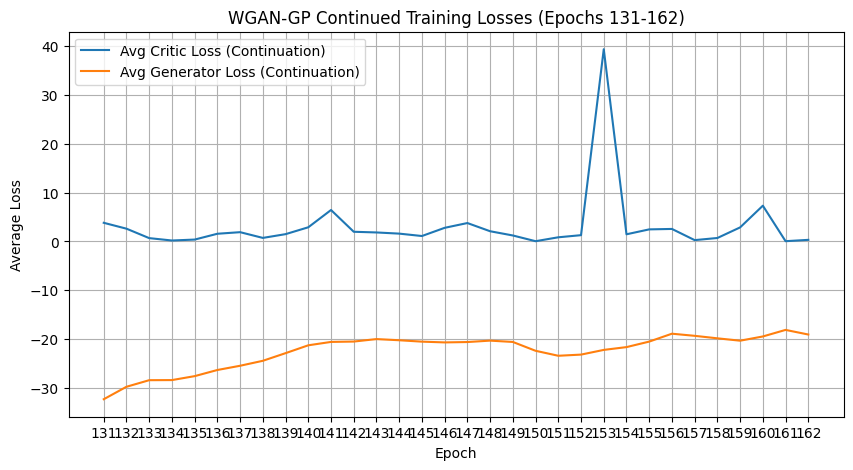

Updated 'critic' and 'generator' variables with weights from continued training.


In [13]:
# Cell 12.5: Continue WGAN-GP Training from Epoch 70 to 85 (loading weights - Build Fix Attempt 2)

import tensorflow as tf
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import logging # Use logging setup from Cell 1
# import fnmatch # Ensure fnmatch is imported if used later

print("\n--- Continuing WGAN-GP Training (Loading Weights) ---")

# --- Configuration ---
load_epoch = 130
start_epoch = load_epoch + 1
end_epoch = 162
continue_epochs = end_epoch - load_epoch

# Parameters (should match Cell 11/12 setup)
# Ensure these are correctly defined from previous cells:
# latent_dim, train_data_path, gan_batch_size, gp_weight, n_critic
# mel_spectrogram_shape (needed to recreate models)
# Learning rates from Cell 11 (use the ones you found most stable)
cont_critic_lr = 1e-5  # Example: Use the potentially lowered LR
cont_gen_lr = 1e-5     # Example: Use the potentially lowered LR

# --- Corrected File Paths for .weights.h5 ---
generator_weights_load_path = f'generator_wgan_sa_epoch_{load_epoch}.weights.h5'
critic_weights_load_path = f'critic_wgan_sa_epoch_{load_epoch}.weights.h5'

# --- Ensure Model Creation Functions and SelfAttention Class are Defined ---
# Make sure Cell 7 (SelfAttention), Cell 8 (create_generator), Cell 9 (create_critic)
# definitions were executed earlier in the notebook.
if 'SelfAttention' not in locals(): raise NameError("SelfAttention class definition not found. Ensure Cell 7 was executed.")
if 'create_generator' not in locals(): raise NameError("create_generator function definition not found. Ensure Cell 8 was executed.")
if 'create_critic' not in locals(): raise NameError("create_critic function definition not found. Ensure Cell 9 was executed.")
if 'mel_spectrogram_shape' not in locals(): raise NameError("mel_spectrogram_shape variable not found. Ensure Cell 11 was executed.")
if 'N_MELS' not in locals() or 'TARGET_FRAMES' not in locals(): raise NameError("N_MELS or TARGET_FRAMES not defined. Ensure Cell 11 was executed.")
if 'latent_dim' not in locals(): raise NameError("latent_dim not defined. Ensure Cell 11 was executed.")


# --- Recreate Model Structures ---
print("Recreating model structures...")
generator_cont = create_generator(latent_dim, mel_spectrogram_shape)
critic_cont = create_critic(mel_spectrogram_shape)
print("Model structures recreated.")

# ---> BUILD MODELS VIA DUMMY FORWARD PASS <---
print("Building models via dummy forward pass...")
# Create dummy input tensors with batch size 1
dummy_critic_input = tf.zeros((1, N_MELS, TARGET_FRAMES, 1), dtype=tf.float32)
dummy_generator_input = tf.zeros((1, latent_dim), dtype=tf.float32)

try:
    # Call the models with the dummy inputs
    _ = critic_cont(dummy_critic_input, training=False) # training=False might be safer here
    _ = generator_cont(dummy_generator_input, training=False)
    print("Models built successfully via dummy pass.")
    # You can optionally print summary again to confirm layers are built
    # print("Critic Summary after build:")
    # critic_cont.summary()
except Exception as e:
    raise RuntimeError(f"Error building models via dummy pass: {e}")


# --- Load Weights ---
# Load generator weights (optional, if file exists)
# ... (loading logic remains the same as before) ...
if os.path.exists(generator_weights_load_path):
    print(f"Loading generator weights from: {generator_weights_load_path}")
    try:
        generator_cont.load_weights(generator_weights_load_path)
        print("Generator weights loaded successfully.")
    except Exception as e:
        print(f"Warning: Error loading generator weights: {e}. Generator starts with initial weights.")
else:
    print(f"Generator weights file not found: {generator_weights_load_path}. Generator starts with initial weights.")

# Load critic weights (Mandatory)
if not os.path.exists(critic_weights_load_path):
    raise FileNotFoundError(f"Critic weights file not found: {critic_weights_load_path}")

print(f"Loading critic weights from: {critic_weights_load_path}")
try:
    critic_cont.load_weights(critic_weights_load_path) # Now this *really* should work
    print("Critic weights loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading critic weights after build: {e}")


# --- Define Optimizers (Redefine for clarity/safety) ---
# ... (optimizer definitions remain the same) ...
critic_optimizer_cont = tf.keras.optimizers.Adam(learning_rate=cont_critic_lr, beta_1=0.5, beta_2=0.9)
generator_optimizer_cont = tf.keras.optimizers.Adam(learning_rate=cont_gen_lr, beta_1=0.5, beta_2=0.9)
print("Optimizers redefined.")

# --- Redefine Training Functions (to use loaded models/optimizers) ---
# ... (training function definitions remain the same) ...
def critic_loss_cont(real_output, fake_output):
    real_output = tf.cast(real_output, tf.float32); fake_output = tf.cast(fake_output, tf.float32)
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
def generator_loss_cont(fake_output):
    fake_output = tf.cast(fake_output, tf.float32)
    return -tf.reduce_mean(fake_output)
def gradient_penalty_cont(batch_size, real_images, fake_images):
    if real_images.dtype != fake_images.dtype: real_images = tf.cast(real_images, fake_images.dtype)
    alpha_shape = [tf.shape(real_images)[0]] + [1] * (len(real_images.shape) - 1)
    alpha = tf.random.uniform(shape=alpha_shape, minval=0., maxval=1., dtype=real_images.dtype)
    interpolated = real_images + alpha * (fake_images - real_images)
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated); pred = critic_cont(interpolated, training=True); pred = tf.cast(pred, tf.float32)
    grads = gp_tape.gradient(pred, [interpolated])
    if grads is None or grads[0] is None: logging.warning("Gradients are None in gradient_penalty_cont."); return tf.constant(0.0, dtype=tf.float32)
    grads = grads[0]; grads = tf.cast(grads, tf.float32)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=tf.range(1, tf.rank(grads)))); gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp * gp_weight
@tf.function
def train_step_cont(real_images):
    current_batch_size = tf.shape(real_images)[0]; noise = tf.random.normal([current_batch_size, latent_dim]); total_crit_loss = tf.constant(0.0, dtype=tf.float32)
    for _ in tf.range(n_critic):
        with tf.GradientTape() as crit_tape:
            fake_images = generator_cont(noise, training=True); real_output = critic_cont(real_images, training=True); fake_output = critic_cont(fake_images, training=True)
            crit_loss = critic_loss_cont(real_output, fake_output); gp = gradient_penalty_cont(current_batch_size, real_images, fake_images); total_crit_loss = crit_loss + gp
        crit_gradients = crit_tape.gradient(total_crit_loss, critic_cont.trainable_variables); valid_grads_and_vars = [(g, v) for g, v in zip(crit_gradients, critic_cont.trainable_variables) if g is not None]
        if len(valid_grads_and_vars) < len(critic_cont.trainable_variables): tf.print("Warning: Some critic gradients are None in cont step.")
        if len(valid_grads_and_vars) > 0: critic_optimizer_cont.apply_gradients(valid_grads_and_vars)
    with tf.GradientTape() as gen_tape:
        fake_images_gen = generator_cont(noise, training=True); fake_output_gen = critic_cont(fake_images_gen, training=True); gen_loss = generator_loss_cont(fake_output_gen)
    gen_gradients = gen_tape.gradient(gen_loss, generator_cont.trainable_variables); valid_grads_and_vars_gen = [(g, v) for g, v in zip(gen_gradients, generator_cont.trainable_variables) if g is not None]
    if len(valid_grads_and_vars_gen) < len(generator_cont.trainable_variables): tf.print("Warning: Some generator gradients are None in cont step.")
    if len(valid_grads_and_vars_gen) > 0: generator_optimizer_cont.apply_gradients(valid_grads_and_vars_gen)
    return total_crit_loss, gen_loss


# --- Data Generator ---
# ... (generator initialization and step calculation remain the same) ...
print("Initializing data generator for continued training...")
train_gen_gan_cont = data_generator_gan(train_data_path, batch_size=gan_batch_size)
if train_gen_gan_cont is None: raise RuntimeError("Failed to initialize GAN data generator.")
# Use function from Cell 13 or define count_total_files here if needed
# This counts both real and fake, data_generator_gan only uses fake
# We need the count of fake files only for the GAN generator steps
fake_files_count_cont = 0
try:
    fake_dir_cont = os.path.join(train_data_path, 'fake')
    if os.path.exists(fake_dir_cont):
        fake_files_count_cont = len([f for f in os.listdir(fake_dir_cont) if f.endswith('.wav')])
except Exception as e:
     print(f"Error counting fake files for continued training: {e}")

if gan_batch_size <= 0: raise ValueError("GAN Batch size must be positive.")
if fake_files_count_cont == 0: raise ValueError("No fake training files found for GAN.")
gan_steps_per_epoch_cont = int(np.ceil(fake_files_count_cont / float(gan_batch_size))) # Corrected count source
print(f"Using {gan_steps_per_epoch_cont} GAN steps per epoch for continued training.") # Corrected count source


# --- Continue Training Loop ---
# ... (training loop remains the same) ...
print(f"\nContinuing WGAN-GP training from epoch {start_epoch} to {end_epoch}...")
cont_c_loss_history = []; cont_g_loss_history = []
if train_gen_gan_cont is None or gan_steps_per_epoch_cont == 0:
    print("Skipping continued WGAN-GP training: Generator not initialized or no steps per epoch.")
else:
    for epoch in range(start_epoch, end_epoch + 1): # Loop from 71 to 85
        print(f"\nEpoch {epoch}/{end_epoch}")
        epoch_pbar_cont = tqdm(range(gan_steps_per_epoch_cont), desc=f"Epoch {epoch}")
        epoch_c_loss = 0.0; epoch_g_loss = 0.0; batches_processed = 0
        for batch_idx in epoch_pbar_cont:
            try:
                real_spoof_samples_np = next(train_gen_gan_cont); real_spoof_samples = tf.convert_to_tensor(real_spoof_samples_np, dtype=tf.float32)
                if tf.shape(real_spoof_samples)[0] == 0: print(f"Warning: Skipped empty batch at step {batch_idx} (cont)"); continue
                c_loss, g_loss = train_step_cont(real_spoof_samples)
                epoch_c_loss += c_loss.numpy(); epoch_g_loss += g_loss.numpy(); batches_processed += 1
                epoch_pbar_cont.set_postfix({"C Loss": f"{c_loss.numpy():.4f}", "G Loss": f"{g_loss.numpy():.4f}"})
            except StopIteration: print(f"\nGAN Generator exhausted prematurely at batch {batch_idx} (cont). Re-initializing."); train_gen_gan_cont = data_generator_gan(train_data_path, batch_size=gan_batch_size); break
            except Exception as e: logging.error(f"Error during continued WGAN training epoch {epoch}, batch {batch_idx}: {e}", exc_info=True); print(f"\nError during continued WGAN training epoch {epoch}, batch {batch_idx}: {e}"); continue
        if batches_processed > 0: avg_c_loss = epoch_c_loss / batches_processed; avg_g_loss = epoch_g_loss / batches_processed; cont_c_loss_history.append(avg_c_loss); cont_g_loss_history.append(avg_g_loss); print(f"Epoch {epoch} finished. Avg C Loss: {avg_c_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")
        else: print(f"Epoch {epoch} finished. No batches processed."); cont_c_loss_history.append(np.nan); cont_g_loss_history.append(np.nan)
        if (epoch % 5 == 0) or (epoch == end_epoch):
             try: generator_cont.save_weights(f'generator_wgan_sa_epoch_{epoch}.weights.h5'); critic_cont.save_weights(f'critic_wgan_sa_epoch_{epoch}.weights.h5'); print(f"Saved generator and critic weights for epoch {epoch}")
             except Exception as e: print(f"Error saving weights at epoch {epoch} (cont): {e}")
    print(f"\nContinued WGAN-GP training finished at epoch {end_epoch}.")
    plt.figure(figsize=(10, 5)); epoch_range = range(start_epoch, start_epoch + len(cont_c_loss_history)); plt.plot(epoch_range, cont_c_loss_history, label='Avg Critic Loss (Continuation)'); plt.plot(epoch_range, cont_g_loss_history, label='Avg Generator Loss (Continuation)'); plt.title(f'WGAN-GP Continued Training Losses (Epochs {start_epoch}-{end_epoch})'); plt.xlabel('Epoch'); plt.ylabel('Average Loss'); plt.xticks(list(epoch_range)); plt.legend(); plt.grid(True); plt.savefig(os.path.join(FIGURES_DIR, f'gan_loss_cont_{start_epoch}_to_{end_epoch}.png')); plt.show()
    critic = critic_cont; generator = generator_cont
    print("Updated 'critic' and 'generator' variables with weights from continued training.")

In [ ]:
# Cell 13: Train Standalone Classifier (using saved Critic Checkpoint)

# Required Imports (ensure they are loaded from Cell 1 or here)
import tensorflow as tf
import numpy as np
import os
import fnmatch # Needed for finding checkpoint
import matplotlib.pyplot as plt # Needed for PlotTrainingHistory
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint # Needed Callbacks
from tensorflow.keras.models import Sequential # Needed for building detector
from tensorflow.keras.layers import Dense # Needed for building detector
from tensorflow.keras.optimizers import Adam # Needed for compiling

# --- ADD PlotTrainingHistory CLASS DEFINITION HERE ---
# Create a custom callback to save training history plots after each epoch
class PlotTrainingHistory(Callback):
    def __init__(self, model_name='model'):
        super().__init__()
        self.model_name = model_name
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.auc = [] # Added to track AUC
        self.val_auc = [] # Added to track validation AUC

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.auc.append(logs.get('auc')) # Get AUC
        self.val_auc.append(logs.get('val_auc')) # Get val_AUC

        # Plot training history
        plt.figure(figsize=(18, 5))

        # Accuracy Plot
        plt.subplot(1, 3, 1)
        if any(v is not None for v in self.acc): plt.plot(self.acc, label='Training Accuracy')
        if any(v is not None for v in self.val_acc): plt.plot(self.val_acc, label='Validation Accuracy')
        plt.title('Model Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        if any(v is not None for v in self.acc) or any(v is not None for v in self.val_acc): plt.legend()

        # Loss Plot
        plt.subplot(1, 3, 2)
        if any(v is not None for v in self.loss): plt.plot(self.loss, label='Training Loss')
        if any(v is not None for v in self.val_loss): plt.plot(self.val_loss, label='Validation Loss')
        plt.title('Model Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
        if any(v is not None for v in self.loss) or any(v is not None for v in self.val_loss): plt.legend()

        # AUC Plot
        plt.subplot(1, 3, 3)
        if any(v is not None for v in self.auc): plt.plot(self.auc, label='Training AUC')
        if any(v is not None for v in self.val_auc): plt.plot(self.val_auc, label='Validation AUC')
        plt.title('Model AUC'); plt.xlabel('Epoch'); plt.ylabel('AUC')
        if any(v is not None for v in self.auc) or any(v is not None for v in self.val_auc): plt.legend()

        plt.tight_layout()
        filepath = os.path.join(FIGURES_DIR, f'{self.model_name}_epoch_{epoch+1}.png')
        try: plt.savefig(filepath); plt.close()
             #print(f'\nTraining history plot saved to {filepath}') # Less verbose output
        except Exception as e: print(f"\nError saving plot to {filepath}: {e}"); plt.close()
# --- END OF PlotTrainingHistory CLASS DEFINITION ---


# --- Ensure count_total_files function is defined (must run Cell 6 first) ---
if 'count_total_files' not in locals():
    raise NameError("count_total_files function is not defined. Ensure Cell 6 (or equivalent) was executed.")
if 'data_generator_classifier' not in locals():
     raise NameError("data_generator_classifier function is not defined. Ensure Cell 6 (or equivalent) was executed.")


print("\nSetting up Standalone Classifier training...")

# --- Get Parameters (ensure Cell 11 was run or define them here) ---
# Required: classifier_batch_size, train_data_path, dev_data_path,
#           mel_spectrogram_shape, N_MELS, TARGET_FRAMES, FIGURES_DIR
# Example defaults if not run from Cell 11:
if 'classifier_batch_size' not in locals(): classifier_batch_size = 8
if 'train_data_path' not in locals(): train_data_path = 'datasetNEW/train'
if 'dev_data_path' not in locals(): dev_data_path = 'datasetNEW/dev'
if 'N_MELS' not in locals(): N_MELS = 80
if 'TARGET_FRAMES' not in locals(): TARGET_FRAMES = 126
if 'mel_spectrogram_shape' not in locals(): mel_spectrogram_shape = (N_MELS, TARGET_FRAMES)
if 'FIGURES_DIR' not in locals(): FIGURES_DIR = 'training_figures_wgan_sa'; os.makedirs(FIGURES_DIR, exist_ok=True)
if 'classifier_epochs' not in locals(): classifier_epochs = 50 # Define epochs for this training

# --- Create Data Generators for Classifier ---
train_gen_clf = data_generator_classifier(train_data_path, batch_size=classifier_batch_size)
dev_gen_clf = data_generator_classifier(dev_data_path, batch_size=classifier_batch_size, shuffle=False)

# --- Calculate steps for Classifier Training ---
train_samples_count = count_total_files(train_data_path)
dev_samples_count = count_total_files(dev_data_path)
if classifier_batch_size <= 0: raise ValueError("Classifier batch size must be positive.")
clf_steps_per_epoch = int(np.ceil(train_samples_count / float(classifier_batch_size))) if train_samples_count > 0 else 0
clf_validation_steps = int(np.ceil(dev_samples_count / float(classifier_batch_size))) if dev_samples_count > 0 else 0
print(f"Classifier Train Steps/Epoch: {clf_steps_per_epoch}, Validation Steps: {clf_validation_steps}")


# --- Build the Spoof Detector Model FROM SAVED CRITIC WEIGHTS ---
# Ensure create_critic and SelfAttention are defined (must run Cell 9 and Cell 7)
if 'create_critic' not in locals(): raise NameError("create_critic function not found.")
if 'SelfAttention' not in locals(): raise NameError("SelfAttention class definition not found.")

# Find latest *trained* critic weights
critic_model_pattern = 'critic_wgan_sa_epoch_*.weights.h5'
list_of_critic_files = [f for f in os.listdir('.') if fnmatch.fnmatch(f, critic_model_pattern)]
latest_critic_weights_file = None
latest_epoch_num = -1
if list_of_critic_files:
     try: # Find the highest epoch number
          epochs_found = [int(f.split('_')[-1].split('.')[0]) for f in list_of_critic_files]
          latest_epoch_num = max(epochs_found)
          latest_critic_weights_file = f'critic_wgan_sa_epoch_{latest_epoch_num}.weights.h5'
          print(f"Found latest critic weights file from epoch {latest_epoch_num}: {latest_critic_weights_file}")
     except (ValueError, IndexError):
          print("Could not parse epoch numbers from critic weight files. Searching by time.")
          # Fallback: find the most recently modified file matching the pattern
          try:
              latest_critic_weights_file = max(list_of_critic_files, key=os.path.getmtime)
              print(f"Found most recent critic weights file by time: {latest_critic_weights_file}")
          except ValueError:
               print("No critic weight files found.")

# Recreate critic structure
print("Recreating base critic structure...")
critic_base = create_critic(mel_spectrogram_shape)

# Build via dummy pass
print("Building critic structure...")
dummy_critic_input = tf.zeros((1, N_MELS, TARGET_FRAMES, 1), dtype=tf.float32)
try:
    _ = critic_base(dummy_critic_input, training=False)
    print("Critic structure built.")
except Exception as e:
    raise RuntimeError(f"Error building critic structure: {e}")

# Load weights if found
if latest_critic_weights_file and os.path.exists(latest_critic_weights_file):
    print(f"Loading critic weights from: {latest_critic_weights_file}")
    try:
        critic_base.load_weights(latest_critic_weights_file)
        print("Critic weights loaded successfully.")
    except Exception as e:
         print(f"ERROR loading weights into critic_base: {e}. Classifier training will start from scratch.")
         # Decide if you want to raise an error or just train from scratch
         # raise RuntimeError("Failed to load crucial weights!")
else:
    print("No pre-trained critic weights found. Classifier training will start from scratch.")

# --- Create the final classifier ---
critic_base.trainable = True # Ensure fine-tuning is possible

spoof_detector = Sequential(name='spoof_detector')
for layer in critic_base.layers[:-1]: # Copy layers except final Dense(1)
    spoof_detector.add(layer)
spoof_detector.add(Dense(1, activation='sigmoid', name='classifier_output'))

# Build the spoof_detector model
spoof_detector_input_shape = (None,) + critic_base.input_shape[1:]
spoof_detector.build(input_shape=spoof_detector_input_shape)

print("\n--- Spoof Detector (Classifier) Summary ---")
spoof_detector.summary()

# --- Callbacks for Classifier Training ---
reduce_lr = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=4, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True, verbose=1)

checkpoint_dir_clf = './training_checkpoints_spoof_detector_wgan_sa'
os.makedirs(checkpoint_dir_clf, exist_ok=True)
checkpoint_prefix_clf = os.path.join(checkpoint_dir_clf, "clf_ep{epoch:02d}-auc{val_auc:.4f}.weights.h5")

checkpoint_callback_clf = ModelCheckpoint(
    filepath=checkpoint_prefix_clf,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Plotting callback (Class definition is now at the top of this cell)
# The check 'if PlotTrainingHistory not in locals()' should no longer be needed here
plot_training_callback = PlotTrainingHistory(model_name='spoof_detector_wgan_sa')


# --- Compile and Train the Classifier ---
classifier_optimizer = Adam(learning_rate=1e-5) # Start with low LR for fine-tuning
spoof_detector.compile(
    optimizer=classifier_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("\nStarting Standalone Classifier training...")

if clf_steps_per_epoch > 0 and clf_validation_steps > 0 and train_gen_clf is not None and dev_gen_clf is not None:
    history = spoof_detector.fit(
        train_gen_clf,
        steps_per_epoch=clf_steps_per_epoch,
        epochs=classifier_epochs, # Use classifier_epochs defined earlier
        validation_data=dev_gen_clf,
        validation_steps=clf_validation_steps,
        callbacks=[reduce_lr, early_stopping, checkpoint_callback_clf, plot_training_callback],
    )

    # --- Save the final state (best weights should be restored) ---
    print("\nSaving final classifier model (best weights should be restored)...")
    try:
        custom_objects = {'SelfAttention': SelfAttention}
        spoof_detector.save('spoof_detector_best_val_auc_wgan_sa.keras', custom_objects=custom_objects)
        print("Saved final classifier model as spoof_detector_best_val_auc_wgan_sa.keras")
    except Exception as e:
        print(f"\nError saving final classifier model: {e}. Saving weights only.")
        spoof_detector.save_weights('spoof_detector_best_val_auc_wgan_sa.weights.h5')

else:
    print("Skipping classifier training: steps are zero or generators are None.")

NameError: count_total_files function is not defined. Ensure Cell 6 (or equivalent) was executed.

In [ ]:
# Cell 14: Evaluation (Load Specific Checkpoint Weights)

import tensorflow as tf
import numpy as np
import os

# --- Ensure Prerequisites are Met (Definitions from previous cells) ---
# These need to be defined/executed before this cell runs:
# - N_MELS, TARGET_FRAMES, classifier_batch_size, eval_data_path, mel_spectrogram_shape (from Cell 11 or 13)
# - SelfAttention class (from Cell 7)
# - create_critic function (from Cell 9)
# - data_generator_classifier function (from Cell 6)
# - count_total_files function (from Cell 6 or 13)

print("\nEvaluating Spoof Detector using specific checkpoint...")

# --- Define Path to the SPECIFIC Weights File ---
model_weights_path = os.path.join('training_checkpoints_spoof_detector_wgan_sa', 'clf_ep28-auc0.9800.weights.h5')
spoof_detector_eval = None
eval_loss, eval_accuracy, eval_auc = None, None, None # Initialize results

# --- Check Prerequisites ---
if 'SelfAttention' not in locals(): raise NameError("SelfAttention class definition not found.")
if 'create_critic' not in locals(): raise NameError("create_critic function not found.")
if 'mel_spectrogram_shape' not in locals(): raise NameError("mel_spectrogram_shape not defined.")
if 'N_MELS' not in locals() or 'TARGET_FRAMES' not in locals(): raise NameError("N_MELS/TARGET_FRAMES not defined.")

# --- Recreate the Model Structure ---
print("Recreating model structure for evaluation...")
try:
    critic_base_eval = create_critic(mel_spectrogram_shape)
    # Create the final classifier structure
    spoof_detector_eval = tf.keras.models.Sequential(name='spoof_detector_eval')
    for layer in critic_base_eval.layers[:-1]: # Copy layers except final Dense(1)
        spoof_detector_eval.add(layer)
    spoof_detector_eval.add(tf.keras.layers.Dense(1, activation='sigmoid', name='classifier_output'))

    # Build the model structure using a dummy pass
    print("Building model structure...")
    dummy_input_eval = tf.zeros((1, N_MELS, TARGET_FRAMES, 1), dtype=tf.float32)
    _ = spoof_detector_eval(dummy_input_eval, training=False)
    print("Model structure built.")
    spoof_detector_eval.summary() # Display summary to confirm structure
except Exception as e:
    print(f"Error recreating model structure: {e}")
    spoof_detector_eval = None # Prevent proceeding

# --- Load the Specific Weights ---
if spoof_detector_eval is not None:
    if os.path.exists(model_weights_path):
        print(f"Loading specific weights for evaluation: {model_weights_path}")
        try:
            spoof_detector_eval.load_weights(model_weights_path)
            print("Weights loaded successfully.")
            # Re-compile after loading weights
            print("Compiling model...")
            spoof_detector_eval.compile(
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
             )
            print("Model compiled.")
        except Exception as e:
            print(f"Error loading specified weights: {e}")
            print("Evaluation cannot proceed.")
            spoof_detector_eval = None # Mark as failed
    else:
        print(f"Specified weights file not found: {model_weights_path}")
        print("Evaluation cannot proceed.")
        spoof_detector_eval = None # Mark as failed


# --- Perform Evaluation ---
if spoof_detector_eval:
    # Ensure necessary parameters/functions for generator/steps are defined
    if 'classifier_batch_size' not in locals(): raise NameError("classifier_batch_size not defined.")
    if 'eval_data_path' not in locals(): raise NameError("eval_data_path not defined.")
    if 'data_generator_classifier' not in locals(): raise NameError("data_generator_classifier not defined.")
    if 'count_total_files' not in locals(): raise NameError("count_total_files not defined.")

    # Create Evaluation Generator
    print("Initializing evaluation data generator...")
    eval_gen_clf = data_generator_classifier(eval_data_path, batch_size=classifier_batch_size, shuffle=False)

    # Calculate Evaluation Steps
    eval_samples_count = count_total_files(eval_data_path)
    if classifier_batch_size <= 0: raise ValueError("Classifier batch size must be positive.")
    eval_steps = int(np.ceil(eval_samples_count / float(classifier_batch_size))) if eval_samples_count > 0 else 0
    print(f"Using {eval_steps} steps for evaluation.")

    # Evaluate
    if eval_steps > 0 and eval_gen_clf is not None:
        print("Running model.evaluate...")
        try:
            results = spoof_detector_eval.evaluate(
                eval_gen_clf,
                steps=eval_steps,
                verbose=1
            )

            print("\n--- Evaluation Results (Epoch 28 Weights) ---")
            # Store results for potential use in Cell 15
            eval_loss = results[0]
            eval_accuracy = results[1]
            eval_auc = results[2]
            print(f"Loss: {eval_loss:.4f}")
            print(f"Accuracy: {eval_accuracy:.4f}")
            print(f"AUC: {eval_auc:.4f}")
            print("-------------------------------------------")
        except Exception as e:
             print(f"An error occurred during model.evaluate: {e}")
             eval_loss, eval_accuracy, eval_auc = None, None, None # Reset results on error
    else:
        print("Skipping evaluation because eval_steps is zero or generator failed.")
else:
    print("Skipping evaluation because the model structure could not be created or weights failed to load.")

# Clean up generator if needed (optional)
# del eval_gen_clf


Evaluating Spoof Detector using specific checkpoint...
Recreating model structure for evaluation...
Building model structure...
Model structure built.


Model: "spoof_detector_eval"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (1, 40, 63, 64)        │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (1, 40, 63, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (1, 20, 32, 128)       │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (1, 20, 32, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (1, 20, 32, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_4                │ (1, 20, 32, 128)       │        37,153 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (1, 10, 16, 256)       │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (1, 10, 16, 256)       │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (1, 10, 16, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (1, 40960)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (1, 1)                 │        40,961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,330 (2.81 MB)

 Trainable params: 735,330 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

Loading specific weights for evaluation: training_checkpoints_spoof_detector_wgan_sa/clf_ep28-auc0.9800.weights.h5
Weights loaded successfully.
Compiling model...
Model compiled.
Initializing evaluation data generator...
Using 8905 steps for evaluation.
Running model.evaluate...
Using class weights: {1: 4.842760027192386, 0: 0.557567076797846} for path datasetNEW/eval
8904/8905 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8559 - auc: 0.8316 - loss: 0.8972

2025-04-06 23:22:38.352534: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 248 bytes spill stores, 248 bytes spill loads

2025-04-06 23:22:38.619887: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 108 bytes spill stores, 108 bytes spill loads

2025-04-06 23:22:38.625009: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 64 bytes spill stores, 64 bytes spill loads

2025-04-06 23:22:38.769556: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 220 bytes spill stores, 184 bytes spill loads

2025-04-06 23:22:38.842154: I external

8905/8905 ━━━━━━━━━━━━━━━━━━━━ 791s 89ms/step - accuracy: 0.8559 - auc: 0.8316 - loss: 0.8971

--- Evaluation Results (Epoch 28 Weights) ---
Loss: 0.4832
Accuracy: 0.8459
AUC: 0.9274
-------------------------------------------



Generating Final Reports & Analysis using Specific Checkpoint...
Recreating model structure for reporting...
Building model structure...
Model structure built.
Loading specific weights for reporting: training_checkpoints_spoof_detector_wgan_sa/clf_ep28-auc0.9800.weights.h5
Weights loaded successfully.
Generating predictions on evaluation set for detailed reports...


Predicting for Reports:   0%|          | 0/8905 [00:00<?, ?it/s]

Using class weights: {1: 4.842760027192386, 0: 0.557567076797846} for path datasetNEW/eval

--- Basic Metrics ---
F1 Score (at threshold 0.5): 0.5409


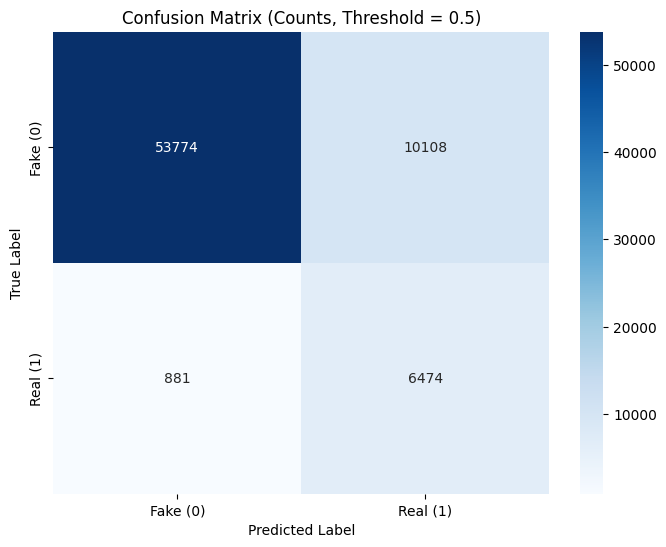

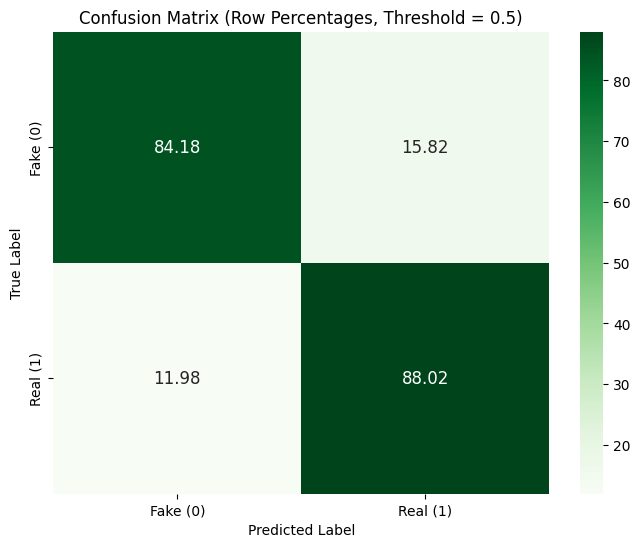


--- Threshold Analysis ---
Best F1 Score: 0.5733 at threshold 0.8990


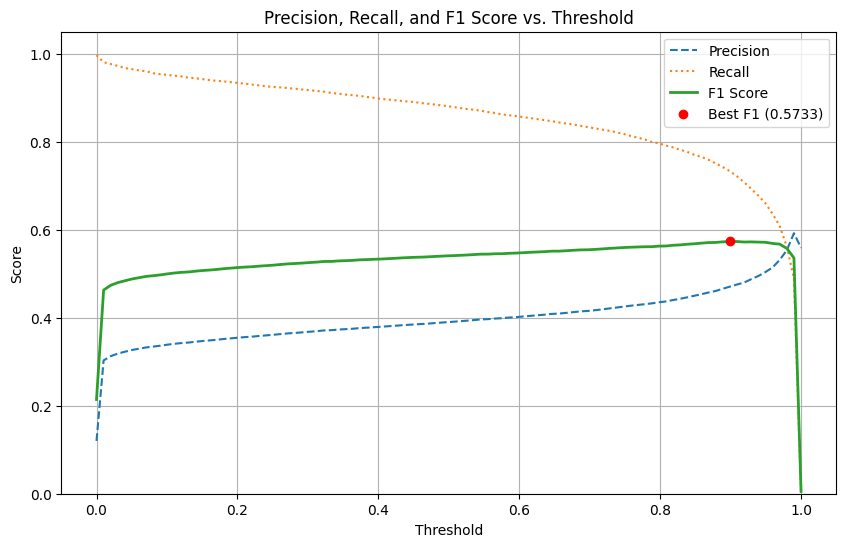


--- Precision-Recall Curve ---
Area Under PR Curve (PR AUC): 0.5894
Average Precision (AP): 0.5894


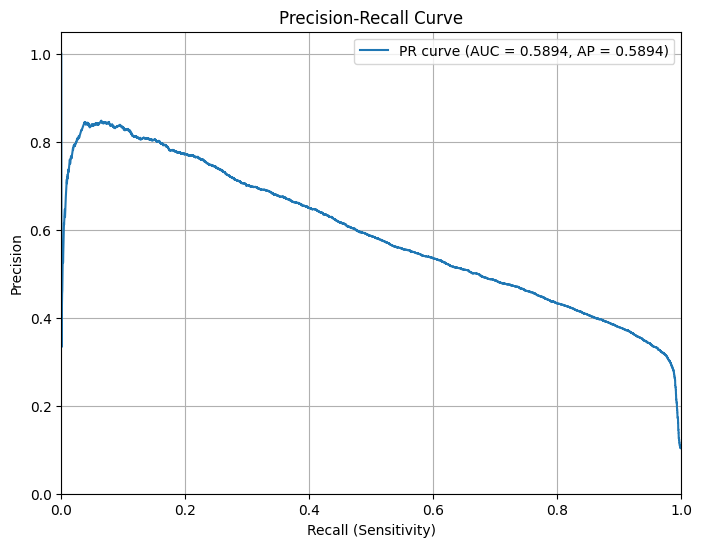


--- Score Calibration ---
Plotting calibration curve (based on evaluation data)...


<Figure size 800x800 with 0 Axes>

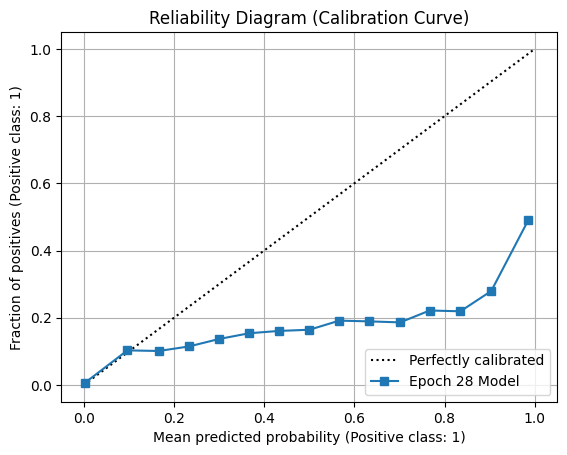


--- EER & t-DCF Analysis (Epoch 28 Weights) ---
EER: 0.1454 at threshold 0.6110
Min t-DCF: 0.9271 at threshold 0.9994

--- Final Summary Metrics (Epoch 28 Weights) ---
Accuracy (@EER thr=0.6110): 0.8546
AUC (recalculated):  0.9306
F1 Score (@0.5):     0.5409
Best F1 Score:     0.5733 (@ thr=0.8990)
EER:                 0.1454 (@ thr=0.6110)
Min t-DCF:           0.9271 (@ thr=0.9994)
-------------------------------------------------


In [ ]:
# Cell 15: Reporting & Analysis (using Specific Checkpoint Weights)

# --- Imports (ensure these are loaded) ---
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # For progress bar
from sklearn.metrics import (confusion_matrix, f1_score, roc_curve, auc,
                             precision_recall_curve, average_precision_score,
                             precision_score, recall_score) # Added P/R score explicitly
from sklearn.calibration import CalibrationDisplay
# from sklearn.isotonic import IsotonicRegression # Can remove if not calibrating

print("\nGenerating Final Reports & Analysis using Specific Checkpoint...")

# --- Parameters ---
# Ensure these are defined: FIGURES_DIR, classifier_batch_size, eval_data_path
if 'FIGURES_DIR' not in locals(): FIGURES_DIR = 'training_figures_wgan_sa'; os.makedirs(FIGURES_DIR, exist_ok=True)
if 'classifier_batch_size' not in locals(): classifier_batch_size = 8
if 'eval_data_path' not in locals(): eval_data_path = 'datasetNEW/eval'

# t-DCF parameters (adjust as needed)
p_target = 0.05
c_miss = 1
c_false_alarm = 1

# --- Define Path to the SPECIFIC Weights File ---
model_weights_path = os.path.join('training_checkpoints_spoof_detector_wgan_sa', 'clf_ep28-auc0.9800.weights.h5')
spoof_detector_report = None # Use a different variable name for clarity

# --- Check Prerequisites & Recreate Model Structure ---
if 'SelfAttention' not in locals(): raise NameError("SelfAttention class definition not found.")
if 'create_critic' not in locals(): raise NameError("create_critic function not found.")
if 'mel_spectrogram_shape' not in locals(): raise NameError("mel_spectrogram_shape not defined.")
if 'N_MELS' not in locals() or 'TARGET_FRAMES' not in locals(): raise NameError("N_MELS/TARGET_FRAMES not defined.")

print("Recreating model structure for reporting...")
try:
    critic_base_report = create_critic(mel_spectrogram_shape)
    spoof_detector_report = tf.keras.models.Sequential(name='spoof_detector_report')
    for layer in critic_base_report.layers[:-1]:
        spoof_detector_report.add(layer)
    spoof_detector_report.add(tf.keras.layers.Dense(1, activation='sigmoid', name='classifier_output'))

    # Build the model structure
    print("Building model structure...")
    dummy_input_report = tf.zeros((1, N_MELS, TARGET_FRAMES, 1), dtype=tf.float32)
    _ = spoof_detector_report(dummy_input_report, training=False)
    print("Model structure built.")
except Exception as e:
    print(f"Error recreating model structure: {e}")
    spoof_detector_report = None # Prevent proceeding


# --- Load the Specific Weights ---
if spoof_detector_report is not None:
    if os.path.exists(model_weights_path):
        print(f"Loading specific weights for reporting: {model_weights_path}")
        try:
            spoof_detector_report.load_weights(model_weights_path)
            print("Weights loaded successfully.")
        except Exception as e:
            print(f"Error loading specified weights: {e}")
            print("Reporting cannot proceed.")
            spoof_detector_report = None # Mark as failed
    else:
        print(f"Specified weights file not found: {model_weights_path}")
        print("Reporting cannot proceed.")
        spoof_detector_report = None # Mark as failed


# --- Proceed only if model is loaded ---
if spoof_detector_report:
    # --- Get Predictions on Evaluation Set ---
    print("Generating predictions on evaluation set for detailed reports...")
    # Ensure data_generator_classifier and count_total_files are defined
    if 'data_generator_classifier' not in locals(): raise NameError("data_generator_classifier not defined.")
    if 'count_total_files' not in locals(): raise NameError("count_total_files not defined.")

    eval_gen_report = data_generator_classifier(eval_data_path, batch_size=classifier_batch_size, shuffle=False)
    eval_samples_count_report = count_total_files(eval_data_path)
    eval_steps_report = int(np.ceil(eval_samples_count_report / float(classifier_batch_size))) if eval_samples_count_report > 0 else 0

    y_pred_scores = []
    y_true_labels = []

    if eval_steps_report > 0 and eval_gen_report is not None:
        for _ in tqdm(range(eval_steps_report), desc="Predicting for Reports"):
            try:
                batch_x, batch_y, _ = next(eval_gen_report)
                if batch_x.size == 0: continue
                # Use the model loaded in *this cell*
                batch_pred = spoof_detector_report.predict(batch_x, verbose=0)
                y_pred_scores.extend(batch_pred.flatten())
                y_true_labels.extend(batch_y)
            except StopIteration:
                print("Eval generator stopped during prediction.")
                break
            except Exception as e:
                print(f"Error during prediction generation: {e}")
                continue # Skip batch on error

        y_pred_scores = np.array(y_pred_scores).astype(np.float32)
        y_true_labels = np.array(y_true_labels).astype(np.int32)

        min_len = min(len(y_pred_scores), len(y_true_labels))
        if min_len == 0:
            print("No predictions generated. Cannot create reports.")
            y_pred_scores = np.array([]) # Ensure empty
        elif min_len < eval_samples_count_report:
             print(f"Warning: Only processed {min_len}/{eval_samples_count_report} samples for reporting.")
             y_pred_scores = y_pred_scores[:min_len]
             y_true_labels = y_true_labels[:min_len]
    else:
        print("Cannot generate predictions (eval_steps=0 or generator failed).")
        y_pred_scores = np.array([]) # Ensure empty


    # --- Perform Analysis only if predictions exist ---
    if y_pred_scores.size > 0:

        # --- 1. Basic Metrics (F1 @ 0.5 & Confusion Matrices) --- # MODIFIED SECTION
        print("\n--- Basic Metrics ---")
        threshold_05 = 0.5
        y_pred_binary_05 = (y_pred_scores >= threshold_05).astype(int)
        f1_at_05 = f1_score(y_true_labels, y_pred_binary_05, zero_division=0)
        print(f"F1 Score (at threshold {threshold_05}): {f1_at_05:.4f}")

        # Calculate Confusion Matrix (Counts)
        cm = confusion_matrix(y_true_labels, y_pred_binary_05)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
        plt.title(f'Confusion Matrix (Counts, Threshold = {threshold_05})')
        plt.ylabel('True Label'); plt.xlabel('Predicted Label')
        plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix_counts_ep28.png')) # Updated filename
        plt.show()

        # Calculate Confusion Matrix (Row Percentages)
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        # Handle division by zero if a class has zero true samples in the eval set
        with np.errstate(divide='ignore', invalid='ignore'):
             cm_perc = cm / cm_sum.astype(float) * 100
             cm_perc = np.nan_to_num(cm_perc) # Replace NaN with 0 if division by zero occurred

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_perc, annot=True, fmt='.2f', cmap='Greens', # Different colormap
                    xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'],
                    annot_kws={"size": 12}) # Adjust font size if needed
        plt.title(f'Confusion Matrix (Row Percentages, Threshold = {threshold_05})')
        plt.ylabel('True Label'); plt.xlabel('Predicted Label')
        plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix_perc_ep28.png')) # New filename
        plt.show()
        # --- END OF MODIFIED SECTION ---


        # --- 2. Threshold Analysis (Precision, Recall, F1) ---
        # ... (This section remains the same as before) ...
        print("\n--- Threshold Analysis ---")
        thresholds_metrics = np.linspace(min(y_pred_scores)+1e-6, max(y_pred_scores)-1e-6, 100)
        precision_scores, recall_scores, f1_scores_thr = [], [], []
        for thr in thresholds_metrics:
            y_pred_binary = (y_pred_scores >= thr).astype(int)
            precision = precision_score(y_true_labels, y_pred_binary, zero_division=0)
            recall = recall_score(y_true_labels, y_pred_binary, zero_division=0)
            f1 = f1_score(y_true_labels, y_pred_binary, zero_division=0)
            precision_scores.append(precision); recall_scores.append(recall); f1_scores_thr.append(f1)
        best_f1_idx = np.argmax(f1_scores_thr); best_f1 = f1_scores_thr[best_f1_idx]; best_f1_threshold = thresholds_metrics[best_f1_idx]
        print(f"Best F1 Score: {best_f1:.4f} at threshold {best_f1_threshold:.4f}")
        plt.figure(figsize=(10, 6)); plt.plot(thresholds_metrics, precision_scores, label='Precision', linestyle='--'); plt.plot(thresholds_metrics, recall_scores, label='Recall', linestyle=':')
        plt.plot(thresholds_metrics, f1_scores_thr, label='F1 Score', linewidth=2); plt.scatter(best_f1_threshold, best_f1, color='red', zorder=5, label=f'Best F1 ({best_f1:.4f})')
        plt.xlabel('Threshold'); plt.ylabel('Score'); plt.title('Precision, Recall, and F1 Score vs. Threshold')
        plt.legend(); plt.grid(True); plt.ylim([0.0, 1.05])
        plt.savefig(os.path.join(FIGURES_DIR, 'prf1_vs_threshold_ep28.png')); plt.show()

        # --- 3. Precision-Recall Curve ---
        # ... (This section remains the same as before) ...
        print("\n--- Precision-Recall Curve ---")
        precision_pr, recall_pr, _ = precision_recall_curve(y_true_labels, y_pred_scores)
        pr_auc_val = auc(recall_pr, precision_pr); avg_precision = average_precision_score(y_true_labels, y_pred_scores)
        print(f"Area Under PR Curve (PR AUC): {pr_auc_val:.4f}"); print(f"Average Precision (AP): {avg_precision:.4f}")
        plt.figure(figsize=(8, 6)); plt.plot(recall_pr, precision_pr, label=f'PR curve (AUC = {pr_auc_val:.4f}, AP = {avg_precision:.4f})')
        plt.xlabel('Recall (Sensitivity)'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
        plt.legend(); plt.grid(True); plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.0])
        plt.savefig(os.path.join(FIGURES_DIR, 'precision_recall_curve_ep28.png')); plt.show()

        # --- 4. Score Calibration Plot ---
        # ... (This section remains the same as before) ...
        print("\n--- Score Calibration ---")
        print("Plotting calibration curve (based on evaluation data)...")
        plt.figure(figsize=(8, 8)); disp = CalibrationDisplay.from_predictions(y_true_labels, y_pred_scores, n_bins=15, name='Epoch 28 Model', strategy='uniform')
        plt.title('Reliability Diagram (Calibration Curve)'); plt.grid(True)
        plt.savefig(os.path.join(FIGURES_DIR, 'calibration_curve_ep28.png')); plt.show()

        # --- 5. EER & t-DCF (Using Original Scores from Epoch 28) ---
        # ... (This section remains the same as before) ...
        print("\n--- EER & t-DCF Analysis (Epoch 28 Weights) ---")
        fpr, tpr, thresholds_roc = roc_curve(y_true_labels, y_pred_scores, pos_label=1)
        fnr = 1 - tpr
        eer_index = np.nanargmin(np.abs(fnr - fpr))
        eer_threshold = thresholds_roc[eer_index] if eer_index < len(thresholds_roc) else thresholds_roc[-1]
        eer = fpr[eer_index]
        print(f"EER: {eer:.4f} at threshold {eer_threshold:.4f}")
        def calculate_tdcf_min(y_true, y_scores, p_target, c_miss, c_fa):
            fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
            fnr = 1 - tpr; min_c_det = float("inf"); min_c_det_threshold = thresholds[0] if len(thresholds) > 0 else 0.0
            c_def = min(c_miss * p_target, c_fa * (1 - p_target))
            if c_def <= 0: return np.inf, min_c_det_threshold
            for i in range(len(thresholds)):
                c_det = c_miss * fnr[i] * p_target + c_fa * fpr[i] * (1 - p_target)
                if c_det < min_c_det: min_c_det = c_det; min_c_det_threshold = thresholds[i]
            return min_c_det / c_def, min_c_det_threshold
        min_tdcf, min_tdcf_thresh = calculate_tdcf_min(y_true_labels, y_pred_scores, p_target, c_miss, c_false_alarm)
        print(f"Min t-DCF: {min_tdcf:.4f} at threshold {min_tdcf_thresh:.4f}")

        # --- Final Summary ---
        print("\n--- Final Summary Metrics (Epoch 28 Weights) ---")
        # Retrieve eval results from Cell 14 if they exist
        acc_disp = f"{eval_accuracy:.4f}" if 'eval_accuracy' in locals() and eval_accuracy is not None else 'N/A (Run Cell 14)'
        auc_disp = f"{eval_auc:.4f}" if 'eval_auc' in locals() and eval_auc is not None else 'N/A (Run Cell 14)'
        final_roc_auc = auc(fpr, tpr) # Recalculate AUC from scores here for consistency
        acc_at_eer_thr = np.mean(y_true_labels == (y_pred_scores >= eer_threshold).astype(int))
        print(f"Accuracy (@EER thr={eer_threshold:.4f}): {acc_at_eer_thr:.4f}")
        print(f"AUC (recalculated):  {final_roc_auc:.4f}")
        print(f"F1 Score (@0.5):     {f1_at_05:.4f}")
        print(f"Best F1 Score:     {best_f1:.4f} (@ thr={best_f1_threshold:.4f})")
        print(f"EER:                 {eer:.4f} (@ thr={eer_threshold:.4f})")
        print(f"Min t-DCF:           {min_tdcf:.4f} (@ thr={min_tdcf_thresh:.4f})")
        print("-------------------------------------------------")

    else: # If y_pred_scores is empty
        print("No predictions were generated, cannot produce detailed reports.")

else: # If spoof_detector_report failed to load
    print("Classifier model not loaded. Skipping report generation.")